In [1]:
import pandas as pd

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [8]:
# 目的変数:　Survived(生存したかどうか、boolean)

train_x = train.drop(['Survived'], axis=1)
train_y = train['Survived']
test_x = test.copy()

In [133]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [135]:
train[train['Sex'] == 'female']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


In [29]:
len(train[train['Survived'] == 1]) / len(train[train['Survived'] == 0])

0.6229508196721312

In [41]:
from sklearn.preprocessing import LabelEncoder

train_x = train_x.drop(['PassengerId'], axis=1)
test_x = test_x.drop(['PassengerId'], axis=1)

KeyError: "['PassengerId'] not found in axis"

In [42]:
train_x = train_x.drop(['Name','Ticket','Cabin'], axis=1)
test_x = test_x.drop(['Name','Ticket','Cabin'], axis=1)

In [45]:
for c in ['Sex', 'Embarked']:
    le = LabelEncoder()
    le.fit(train_x[c].fillna('NA'))

    train_x[c] = le.transform(train_x[c].fillna('NA'))
    test_x[c] = le.transform(test_x[c].fillna('NA'))

In [57]:
test_x[test_x['Embarked'] == 3]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,3,0,47.0,1,0,7.0000,3
3,3,1,27.0,0,0,8.6625,3
4,3,0,22.0,1,1,12.2875,3
5,3,1,14.0,0,0,9.2250,3
7,2,1,26.0,1,1,29.0000,3
...,...,...,...,...,...,...,...
409,3,0,3.0,1,1,13.7750,3
412,3,0,28.0,0,0,7.7750,3
413,3,1,NaN,0,0,8.0500,3
415,3,1,38.5,0,0,7.2500,3


In [59]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.8 MB/s eta 0:00:00


In [61]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=20, random_state=71)
model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=71, ...)

In [66]:
import numpy as np
pred = model.predict_proba(test_x)[:,1]
pred_label = np.where(pred > 0.5, 1, 0)

In [71]:
submission = pd.DataFrame(
    {
        'PassengerId': test['PassengerId'],
        'Survived': pred_label
    }
)
submission.to_csv('submission_first.csv', index=False)

In [89]:
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold

scores_acc = []
scores_logloss = []

kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train_x):
    tr_x,va_x = train_x.iloc[tr_idx],train_x.iloc[va_idx]
    tr_y,va_y = train_y.iloc[tr_idx],train_y.iloc[va_idx]

    model = XGBClassifier(n_estimators=20, random_state=71)
    model.fit(tr_x, tr_y)
    va_pred = model.predict_proba(va_x)[:,1]
    logloss = log_loss(va_y, va_pred)
    acc = accuracy_score(va_y, va_pred > 0.5)
    scores_logloss.append(logloss)
    scores_acc.append(acc)

logloss = np.mean(scores_logloss)
accuracy = np.mean(scores_acc)
print('logloss:', logloss)
print('accuracy:', accuracy)

logloss: 0.43597096881896047
accuracy: 0.8260463378176383


In [102]:
import itertools

param_space = {
    'max_depth': [1,2,3,4,5,6,7],
    'min_child_weight': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
}

param_comb = itertools.product(param_space['max_depth'],param_space['min_child_weight'])

params = []
scores = []
for max_depth, min_child_weight in param_comb:
    score_folds = []

    kf = KFold(n_splits=4, shuffle=True, random_state=71)
    for tr_idx, va_idx in kf.split(train_x):
        tr_x,va_x = train_x.iloc[tr_idx],train_x.iloc[va_idx]
        tr_y,va_y = train_y.iloc[tr_idx],train_y.iloc[va_idx]
    
        model = XGBClassifier(n_estimators=20, random_state=71, max_depth=max_depth, min_child_weight=min_child_weight)
        model.fit(tr_x, tr_y)
        va_pred = model.predict_proba(va_x)[:,1]
        logloss = log_loss(va_y, va_pred)
        score_folds.append(logloss)
    
    score_mean = np.mean(score_folds)
    params.append((max_depth, min_child_weight))
    scores.append(score_mean)

best_idx = np.argsort(scores)[0]
best_param = params[best_idx]

print('max_depth', best_param[0])
print('min_child_weight', best_param[1])

max_depth 3
min_child_weight 3.5


In [ ]:
import itertools

param_space = {
    'max_depth': [1,2,3,4,5,6,7],
    'min_child_weight': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
}

param_comb = itertools.product(param_space['max_depth'],param_space['min_child_weight'])

params = []
scores = []
for max_depth, min_child_weight in param_comb:
    score_folds = []

    kf = KFold(n_splits=4, shuffle=True, random_state=71)
    for tr_idx, va_idx in kf.split(train_x):
        tr_x,va_x = train_x.iloc[tr_idx],train_x.iloc[va_idx]
        tr_y,va_y = train_y.iloc[tr_idx],train_y.iloc[va_idx]
    
        model = XGBClassifier(n_estimators=20, random_state=71, max_depth=3, min_child_weight=3.5)
        model.fit(tr_x, tr_y)
        va_pred = model.predict_proba(va_x)[:,1]
        acc = accuracy_score(va_y, va_pred > 0.5)
        print(acc)
        logloss = log_loss(va_y, va_pred)
        score_folds.append(logloss)
    
    score_mean = np.mean(score_folds)
    params.append((max_depth, min_child_weight))
    scores.append(score_mean)

best_idx = np.argsort(scores)[0]
best_param = params[best_idx]

print('max_depth', best_param[0])
print('min_child_weight', best_param[1])

In [98]:
model = XGBClassifier(n_estimators=20, random_state=71, max_depth=3, min_child_weight=3.5)
model.fit(train_x, train_y)
pred = model.predict_proba(test_x)[:,1]
pred_label = np.where(pred > 0.5, 1, 0)

submission = pd.DataFrame(
    {
        'PassengerId': test['PassengerId'],
        'Survived': pred_label
    }
)
submission.to_csv('submission_cross.csv', index=False)

In [109]:
train.groupby('Sex').sum()['Survived']

Sex
female    233
male      109
Name: Survived, dtype: int64

In [111]:
233 / (233 + 109)

0.6812865497076024

In [112]:
109 / (233 + 109)

0.31871345029239767

In [116]:
train.groupby('Survived').size()

Survived
0    549
1    342
dtype: int64

In [118]:
342 / (549 + 342)

0.3838383838383838

In [124]:
train.groupby(['Survived', 'Sex']).size()

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
dtype: int64

In [127]:
468 / (109 + 468)

0.8110918544194108

In [145]:
train['Survived'][train['Sex'] == 'female'].value_counts()

Survived
1    233
0     81
Name: count, dtype: int64

In [144]:
train['Survived'][train['Sex'] == 'male'].value_counts()

Survived
0    468
1    109
Name: count, dtype: int64

<Axes: xlabel='Sex', ylabel='Survived'>

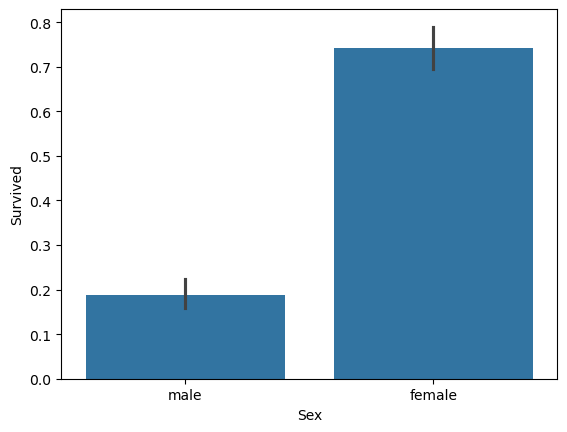

In [149]:
import seaborn as sns
sns.barplot(x=train['Sex'], y=train["Survived"], data=train)

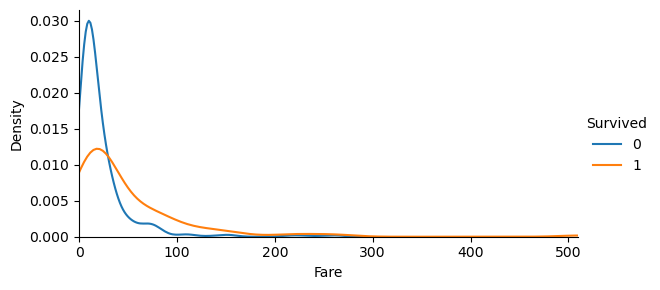

In [160]:
fare = sns.FacetGrid(train, hue="Survived",aspect=2)
fare.map(sns.kdeplot,'Fare')
fare.set(xlim=(0, 510))
fare.add_legend()

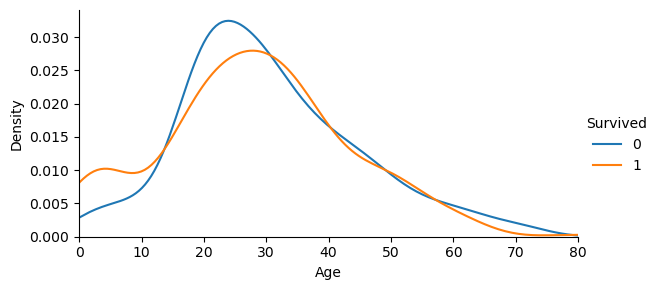

In [161]:
age = sns.FacetGrid(train, hue="Survived",aspect=2)
age.map(sns.kdeplot,'Age')
age.set(xlim=(0, train['Age'].max()))
age.add_legend()

<Axes: xlabel='Parch', ylabel='Survived'>

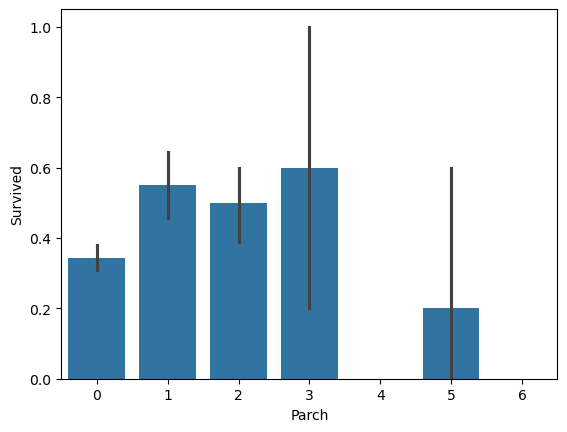

In [203]:
# TicketとPclassは相関あり
# Ticketの開始番号が1→Pclassも1
# Ticketの開始番号が2→Pclassも2
# Ticketの開始番号が3→Pclassも3
# アルファベットから始まるチケット番号は端っことか特殊な場所にある部屋だと思われる
# Cabinは欠損値が多いけどTicketとPclassから想定できるし、特徴量としては余計になりそう（TicketとPclassだけでOK）

# Age、Sex、Pclassの3つは生存率に影響が大きそうなので特徴量として確定
# 家族関係はどうか？

sns.barplot(x=train['Parch'], y=train["Survived"], data=train)

In [211]:
try_x = train_x.drop(['Embarked','Parch','Fare','SibSp'], axis=1)
# model = XGBClassifier(n_estimators=20, random_state=71)
# model.fit(train_x, train_y)

In [212]:
try_x

,Pclass,Sex,Age
0,3,1,22.0
1,1,0,38.0
2,3,0,26.0
3,1,0,35.0
4,3,1,35.0
...,...,...,...
886,2,1,27.0
887,1,0,19.0
888,3,0,NaN
889,1,1,26.0


In [220]:
model_try = XGBClassifier(n_estimators=20, random_state=71)
model_try.fit(try_x, train_y)
try_test_x = test_x.drop(['SibSp', 'Parch', 'Fare', 'Embarked'], axis=1)
pred = model_try.predict_proba(try_test_x)[:,1]
pred_label = np.where(pred > 0.5, 1, 0)

In [301]:
train[(train['Parch'] == 0) & (train['SibSp'] == 0) & (train['Sex'] == 'male')]['Survived'].value_counts()

Survived
0    347
1     64
Name: count, dtype: int64

In [304]:
train['Alone'] = (train['Parch'] == 0) & (train['SibSp'] == 0)

In [440]:
dataset = pd.concat([train,test])
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Alone,Ticket_count,SurName,honorific
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,9.0,Braund,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,8.0,Cumings,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,True,16.0,Heikkinen,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False,6.0,Futrelle,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,True,6.0,Allen,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,NaN,NaN,NaN,NaN
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,NaN,NaN,NaN,NaN
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,NaN,NaN,NaN,NaN
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,NaN,NaN,NaN,NaN


In [454]:
dataset['honorific'] = dataset['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())


In [462]:
dataset.groupby('honorific')['Survived'].mean().sort_values()

honorific
Capt            0.000000
Don             0.000000
Jonkheer        0.000000
Rev             0.000000
Mr              0.156673
Dr              0.428571
Col             0.500000
Major           0.500000
Master          0.575000
Miss            0.697802
Mrs             0.792000
Mme             1.000000
Sir             1.000000
Ms              1.000000
Lady            1.000000
Mlle            1.000000
the Countess    1.000000
Dona                 NaN
Name: Survived, dtype: float64

In [463]:

"""

仕事（だいたい男）job
Dr 医者
Capt 船長
Rev　牧師
Col　大佐（軍人）
Major 軍人


Master 坊ちゃん（若い子供につける）

男
Mr


女性
Miss
Mrs
Mme
Ms
Mlle　フランス語

貴族っぽい敬称nobility
Lady　貴婦人
the Countess　公爵夫人
Dona　ポルトガル圏の貴婦人
Sir　準男爵（イギリス）
Don （スペインの）貴族、紳士（イタリア）聖職者
Jonkheer オランダとベルギーの貴族の敬称
"""


In [469]:
honorific = {}
honorific.update(dict.fromkeys(['Capt','Col','Dr','Major','Rev'], 'Worker'))
honorific.update(dict.fromkeys(['Miss','Mlle'], 'Miss'))
honorific.update(dict.fromkeys(['Mrs','Mme','Ms'], 'Mrs'))
honorific.update(dict.fromkeys(['Mr'], 'Mr'))
honorific.update(dict.fromkeys(['Master'], 'Master'))
honorific.update(dict.fromkeys(['Lady','the Countess','Dona','Sir','Don','Jonkheer'], 'Nobility'))

In [470]:
honorific

{'Capt': 'Worker',
 'Col': 'Worker',
 'Dr': 'Worker',
 'Major': 'Worker',
 'Rev': 'Worker',
 'Miss': 'Miss',
 'Mlle': 'Miss',
 'Mrs': 'Mrs',
 'Mme': 'Mrs',
 'Ms': 'Mrs',
 'Mr': 'Mr',
 'Master': 'Master',
 'Lady': 'Nobility',
 'the Countess': 'Nobility',
 'Dona': 'Nobility',
 'Sir': 'Nobility',
 'Don': 'Nobility',
 'Jonkheer': 'Nobility'}

In [472]:
dataset['honorific'] = dataset['honorific'].map(honorific)

In [487]:
dataset['Alone'] = (dataset['Parch'] == 0) & (dataset['SibSp'] == 0)

In [498]:
train_x = dataset[dataset['Survived'].notnull()]
test_x = dataset[dataset['Survived'].isnull()]

In [502]:
dataset['SurName'] = dataset['Name'].apply(lambda x:x.split(',')[0].strip())

In [504]:
train_x = dataset[dataset['Survived'].notnull()]
test_x = dataset[dataset['Survived'].isnull()]

In [516]:
dataset = pd.get_dummies(dataset['honorific'])

In [520]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Alone,Ticket_count,SurName,honorific
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,9,Braund,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,8,Cumings,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,True,16,Heikkinen,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False,6,Futrelle,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,True,6,Allen,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,True,6,Montvila,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,True,6,Graham,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,False,10,Johnston,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,True,6,Behr,Mr
